In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [3]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [4]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


In [5]:
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:title={'center':'Yen Futures Settle Prices'}, xlabel='Date', ylabel='Settle Price'>

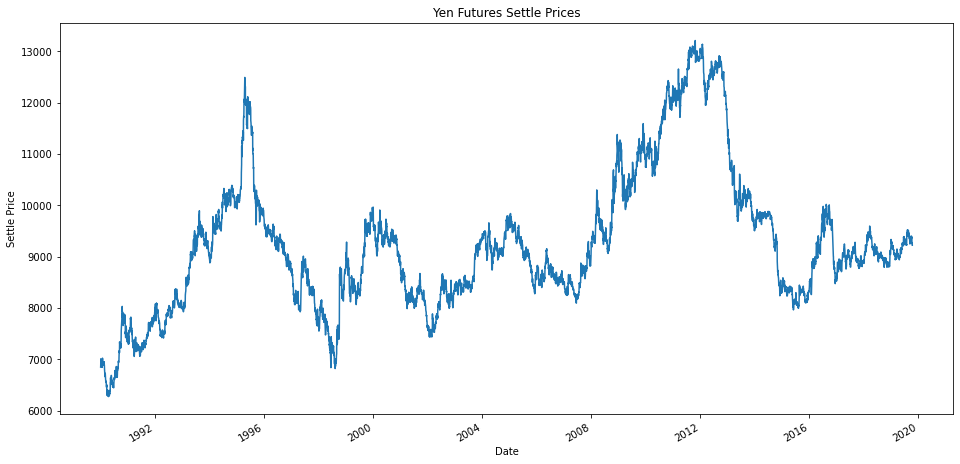

In [8]:
# Plot just the "Settle" column from the dataframe:
yen_futures.Settle.plot(figsize=(16,8), xlabel="Date", ylabel = "Settle Price", title = "Yen Futures Settle Prices")

### Do you see any patterns, long-term and/or short?
It is difficult to determine if there are any long-term or short-term patterns.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [9]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" 
#price into two separate series:
yen_futures_settle_noise, yen_futures_settle_trend = sm.tsa.filters.hpfilter(yen_futures["Settle"])


In [10]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
yen_futures_settle = pd.DataFrame(yen_futures["Settle"])
yen_futures_settle['noise'] = yen_futures_settle_noise
yen_futures_settle['trend'] = yen_futures_settle_trend
yen_futures_settle.head()

,Settle,noise,trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


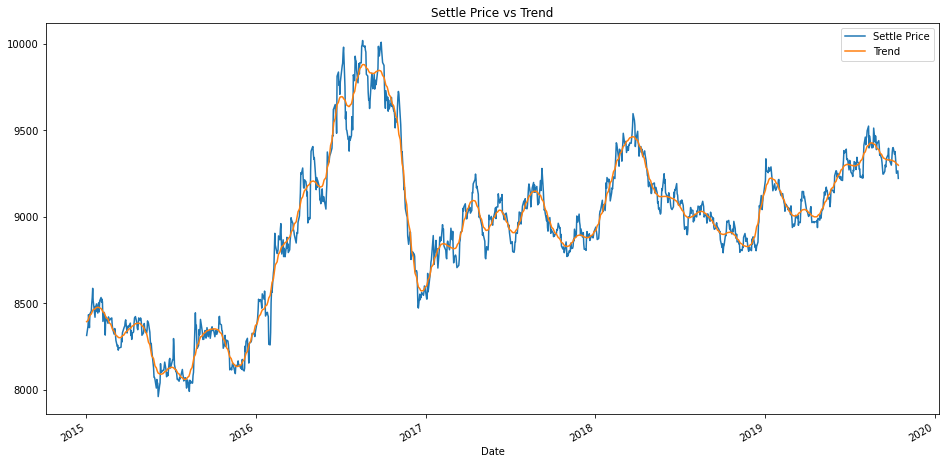

In [12]:
# Plot the Settle Price vs. the Trend for 2015 to the present
yen_futures["Settle"].loc["2015-01-01":].plot(label="Settle Price", figsize=(16,8), title="Settle Price vs Trend")
yen_futures_settle["trend"].loc["2015-01-01":].plot(label="Trend")
plt.legend()


<AxesSubplot:title={'center':'Noise'}, xlabel='Date'>

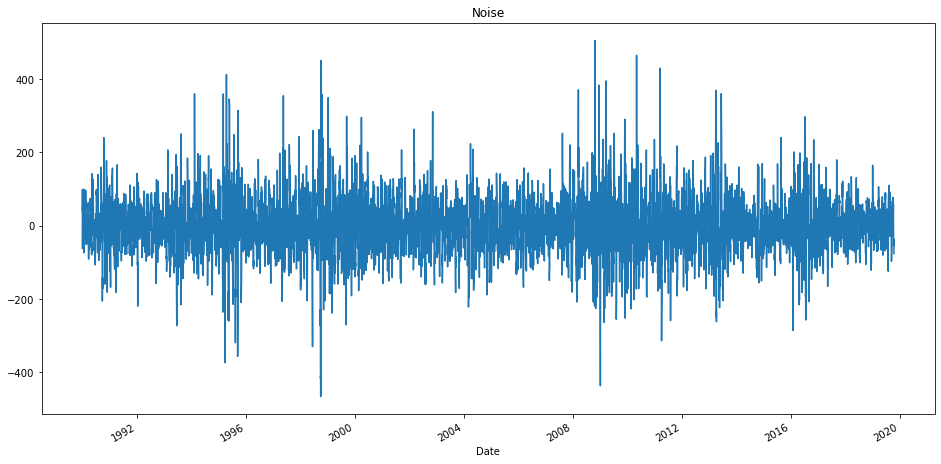

In [14]:
# Plot the Settle Noise
yen_futures_settle["noise"].plot(figsize=(16,8), xlabel="Date", title = "Noise")

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [15]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


<AxesSubplot:xlabel='Date'>

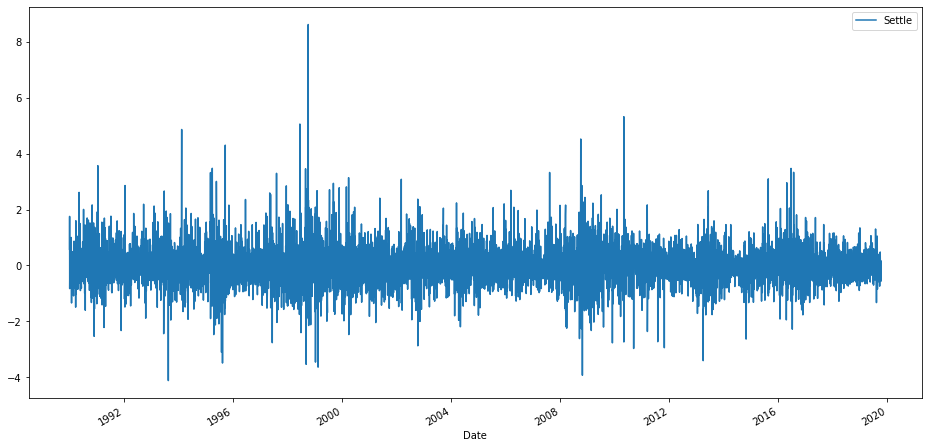

In [16]:
# Stationarity seen
returns.plot(figsize=(16,8))

In [24]:
import statsmodels.api as sm

# Estimate and ARMA model using statsmodels (use order=(2, 1))
# Import the ARMA model
from statsmodels.tsa.arima_model import ARMA
import warnings
warnings.filterwarnings("ignore")

# For the order parameter, the first 2 indicates the number of AR lags
# For the order parameter, the second 1 indicates the number of MA lags
model = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
results = model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05058D+00    |proj g|=  5.17719D-04

At iterate    5    f=  1.05058D+00    |proj g|=  2.15383D-06

At iterate   10    f=  1.05058D+00    |proj g|=  6.60139D-05

At iterate   15    f=  1.05058D+00    |proj g|=  3.63887D-04

At iterate   20    f=  1.05058D+00    |proj g|=  3.50830D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     34      1     0     0   9.770D-07   1.051D+00
  F =   1.0505817371349249     

CONVERG

In [25]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Tue, 09 Nov 2021   AIC                          15798.142
Time:                        10:19:02   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.421      -0.009       0.022
ar.L1.y       -0.3062      1.277     -0.240      0.811      -2.810       2.197
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2947      1.277      0.231      0.818      -2.209       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3349           +0.0000j            3.3349            0.5000
AR.2         -157.1502           +0.0000j          157.1502            0.5000
MA.1           -3.3938           +0.0000j            3.3938            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

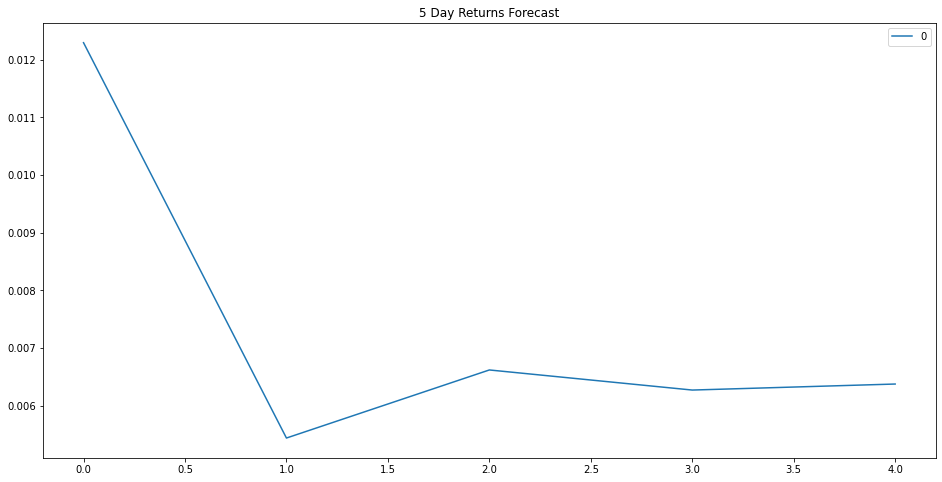

In [26]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast", figsize=(16,8))

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [27]:
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(yen_futures['Settle'], order=(5, 1, 1))

# Fit the model
results1 = model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.58220D+00    |proj g|=  8.65974D-05

At iterate    5    f=  5.58220D+00    |proj g|=  1.02141D-05

At iterate   10    f=  5.58220D+00    |proj g|=  1.07292D-04

At iterate   15    f=  5.58220D+00    |proj g|=  5.59552D-06

At iterate   20    f=  5.58220D+00    |proj g|=  5.48006D-05

At iterate   25    f=  5.58220D+00    |proj g|=  1.42109D-06

At iterate   30    f=  5.58220D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

In [28]:
# Output model summary results:
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Tue, 09 Nov 2021   AIC                          83905.238
Time:                        10:19:21   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3160      0.700      0.451      0.652      -1.056       1.688
ar.L1.D.Settle     0.2826      0.699      0.404      0.686      -1.087       1.652
ar.L2.D.Settle     0.0007      0.016      0.043      0.965      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.031      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0136      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0011      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2977      0.699     -0.426      0.670      -1.667       1.072
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8923           -1.3782j            2.3410           -0.1002
AR.2            1.8923           +1.3782j            2.3410            0.1002
AR.3           -2.2722           -3.0195j            3.7789           -0.3527
AR.4           -2.2722           +3.0195j            3.7789            0.3527
AR.5          -11.1426           -0.0000j           11.1426           -0.5000
MA.1            3.3596           +0.0000j            3.3596            0.0000
-----------------------------------------------------------------------------
"""

### Based on the p-values, is the model a good fit (p < 0.05)?

The p values are all greater than 0.05. So the model is not a good fit.

<AxesSubplot:title={'center':'5 Day Futures Price Forecast'}>

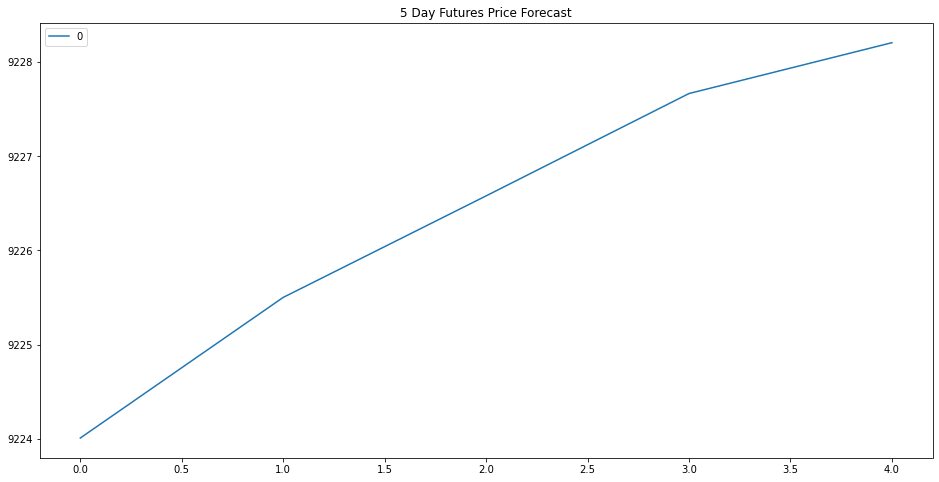

In [29]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results1.forecast(steps=5)[0]).plot(title="5 Day Futures Price Forecast", figsize=(16,8))

###  What does the model forecast will happen to the Japanese Yen in the near term?
In 5 days the Yen will increase to 9228....

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [30]:
import arch 
from arch import arch_model

In [31]:
# Estimate a GARCH model:
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
results2 = model.fit(disp="off")

In [32]:
# Summarize the model results
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Tue, Nov 09 2021   Df Residuals:                     7514
Time:                        10:23:30   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.707e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

### Based on the p-values, is the model a good fit (p < 0.05)?

In [33]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [34]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = results2.forecast(start=last_day, horizon=forecast_horizon)

In [35]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434032,7.475729,7.516851,7.55741,7.597418


In [36]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434032
h.2,7.475729
h.3,7.516851
h.4,7.557410
h.5,7.597418


<AxesSubplot:title={'center':'5 Day Forecast of Volatility'}>

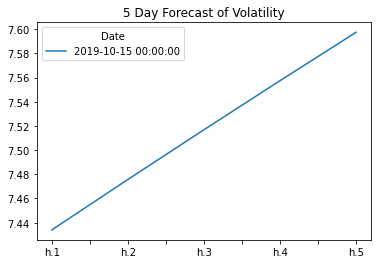

In [37]:
# Plot the final forecast
final.plot(title="5 Day Forecast of Volatility")

---